In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tensorflow as tf

# 1. Make data

In [3]:
X, y = make_classification(n_samples=600, n_features=2, n_informative=2, n_redundant=0, n_classes=3, n_clusters_per_class=1, class_sep=1.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_torch = torch.tensor(X_train_std, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_std, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

X_train_tf = tf.convert_to_tensor(X_train_std, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test_std, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.int32)

# 2. MLP Torch

## 2.1 define MLP model, add dropout

In [11]:
class TorchMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 64)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x) # will turn 1-p neurons off, say x is [0.1, 0.2, 0.3, 0.4] after dropout(x) might be [0.2, 0, 0, 0.8]
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

## 2.2 train with different optimizers

In [21]:
def train_with_optimizer(optimizer_name):
    model = TorchMLP()
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
    elif optimizer_name == "Momentum":
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=0.01, alpha=0.9, weight_decay=1e-4)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    train_losses = []
    test_accuracies = []
    test_losses = []
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        logits = model(X_train_torch)
        loss = criterion(logits, y_train_torch)
        loss.backward()
        optimizer.step()
        scheduler.step() #adjust learning rate
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            test_logits = model(X_test_torch)
            test_loss = criterion(test_logits, y_test_torch)
            pred_labels = torch.argmax(test_logits, dim=1)
            acc = (pred_labels == y_test_torch).float().mean().item()
            test_accuracies.append(acc)
            test_losses.append(test_loss)
    
    return train_losses, test_accuracies, test_losses

In [34]:
optimizers = ["SGD", "Momentum", "RMSprop", "Adam"]
torch_loss_histories = {}
torch_acc_histories = {}
torch_test_loss_histories = {}

for name in optimizers:
    loss, acc, test_loss = train_with_optimizer(name)
    torch_loss_histories[name] = loss
    torch_acc_histories[name] = acc
    torch_test_loss_histories[name] = test_loss

## 2.3 Visualize the loss with different optimizers

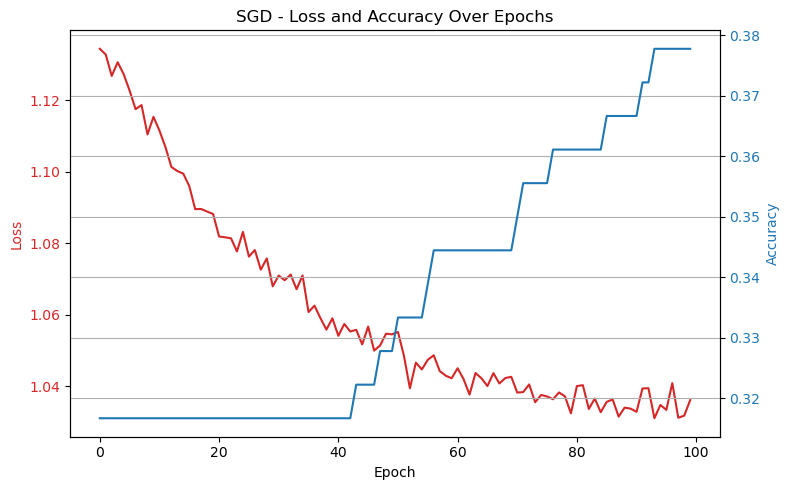

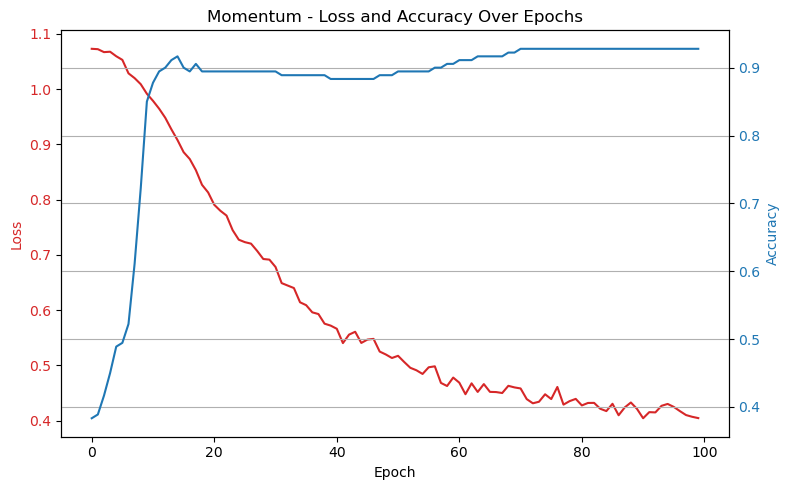

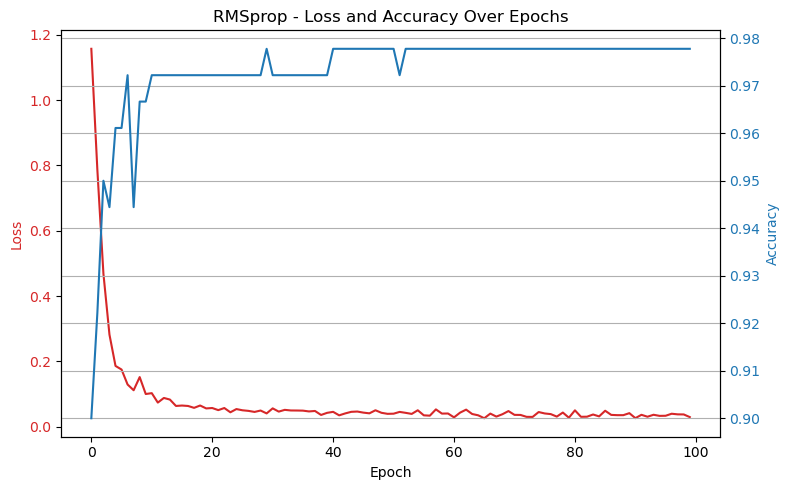

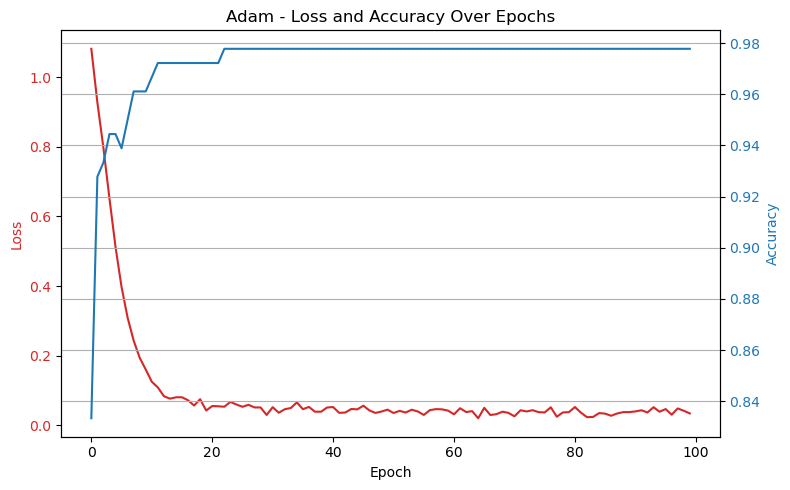

In [35]:
def plot_loss_accuracy_dual_axis(losses, accuracies, optimizer_name):
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # 左轴：训练 Loss
    ax1.plot(losses, color='tab:red', label='Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # 右轴：测试集 Accuracy
    ax2 = ax1.twinx()
    ax2.plot(accuracies, color='tab:blue', label='Accuracy')
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # 标题 & 图例
    plt.title(f"{optimizer_name} - Loss and Accuracy Over Epochs")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

for name in ["SGD", "Momentum", "RMSprop", "Adam"]:
    plot_loss_accuracy_dual_axis(torch_loss_histories[name], torch_acc_histories[name], name)

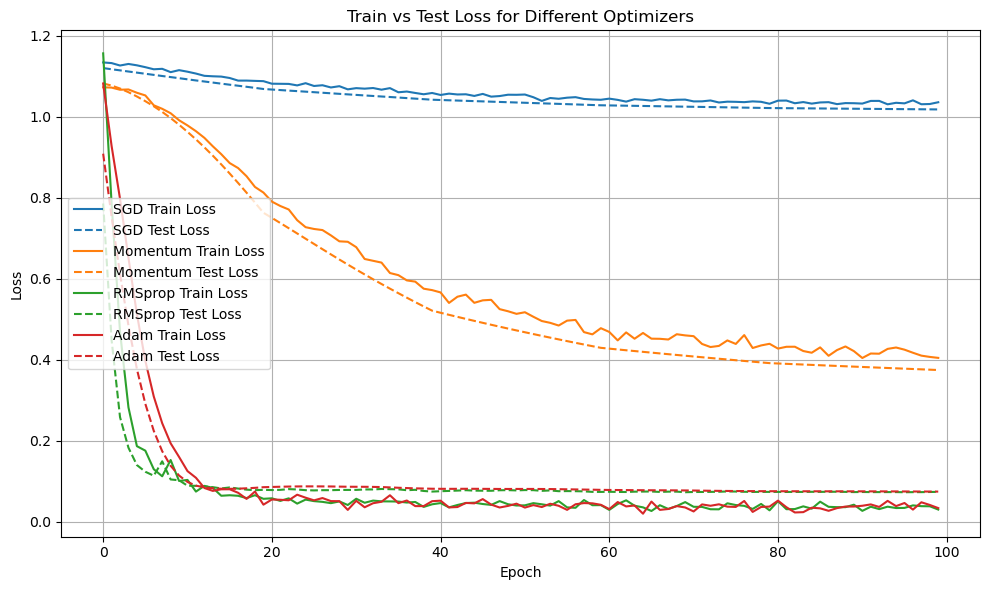

In [36]:
plt.figure(figsize=(10, 6))
colors = {
    "SGD": "tab:blue",
    "Momentum": "tab:orange",
    "RMSprop": "tab:green",
    "Adam": "tab:red"
}
for name in optimizers:
    color = colors[name]
    plt.plot(torch_loss_histories[name], label=f"{name} Train Loss", color=color, linestyle='-')
    plt.plot(torch_test_loss_histories[name], label=f"{name} Test Loss", color=color, linestyle='--')

plt.title("Train vs Test Loss for Different Optimizers")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. MLP tensorflow

## 3.1 Define MLP model, add dropout

In [29]:
class TFMLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.fc1 = tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(1e-4))
        self.relu1 = tf.keras.layers.ReLU()
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.fc2 = tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(1e-4))
        self.relu2 = tf.keras.layers.ReLU()
        self.fc3 = tf.keras.layers.Dense(3, kernel_regularizer=tf.keras.regularizers.l2(1e-4))

    def call(self, x, training=False):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x, training=training)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

## 3.2 Train with different optimizers

In [30]:
def train_tf_model(optimizer_name):
    model = TFMLP()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[20,40,60,80],
        values=[0.01, 0.005, 0.0025, 0.00125, 0.000625]
    )

    if optimizer_name == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
    elif optimizer_name == "Momentum":
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
    elif optimizer_name == "RMSprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule, rho=0.9)
    elif optimizer_name == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model(tf.zeros((1,2)))
    
    train_losses = []
    test_accuracies = []
    test_losses = []

    for epoch in range(100):
        with tf.GradientTape() as tape:
            logits = model(X_train_tf, training=True)
            loss = loss_fn(y_train_tf, logits)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_losses.append(loss.numpy())

        test_logits = model(X_test_tf, training=False)
        test_loss = loss_fn(y_test_tf, test_logits)
        pred_labels = tf.argmax(test_logits, axis=1, output_type=tf.int32)
        acc = tf.reduce_mean(tf.cast(pred_labels == y_test_tf, tf.float32)).numpy()

        test_losses.append(test_loss.numpy())
        test_accuracies.append(acc)
    return train_losses, test_accuracies, test_losses

In [37]:
optimizers = ["SGD", "Momentum", "RMSprop", "Adam"]
tf_loss_histories = {}
tf_acc_histories = {}
tf_test_loss_histories = {}

for name in optimizers:
    print(f"Training with {name}...")
    loss, acc, test_loss = train_tf_model(name)
    tf_loss_histories[name] = loss
    tf_acc_histories[name] = acc
    tf_test_loss_histories[name] = test_loss

Training with SGD...
Training with Momentum...
Training with RMSprop...
Training with Adam...


## 3.3 Visualize the loss with different optimizers

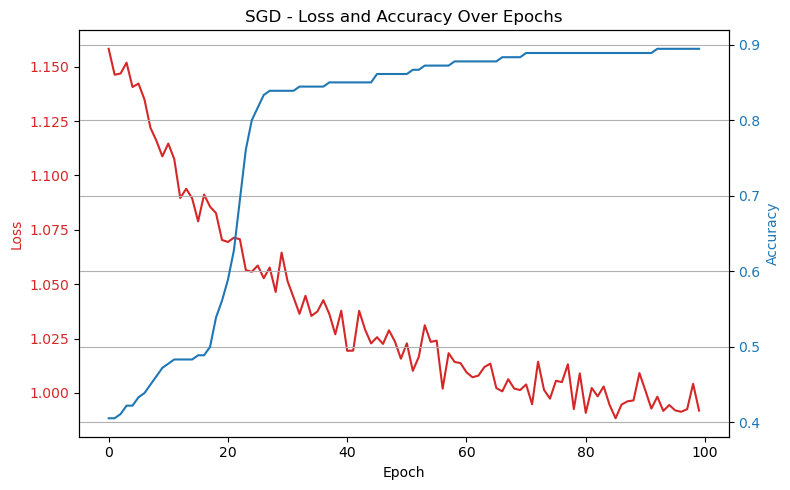

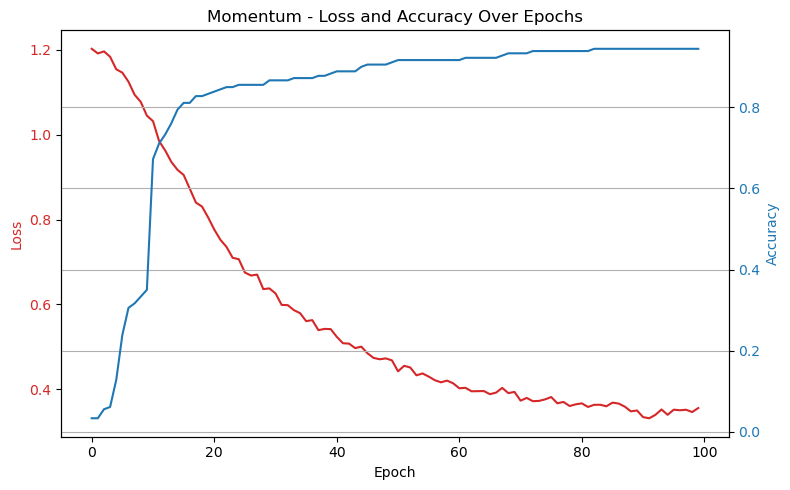

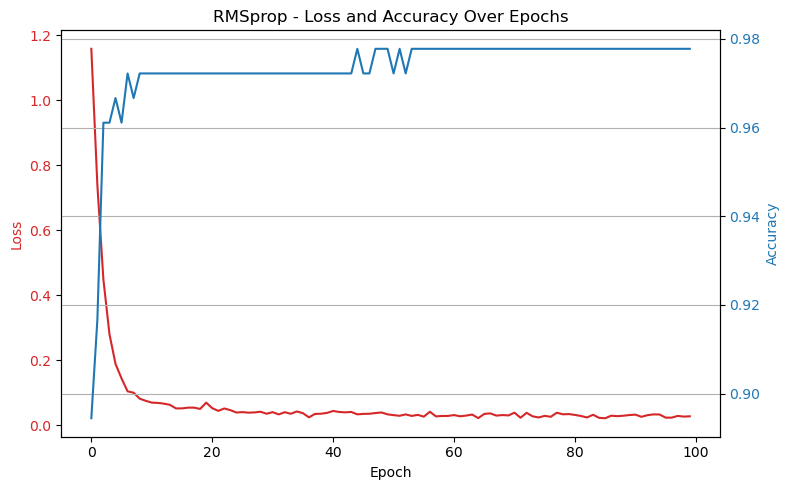

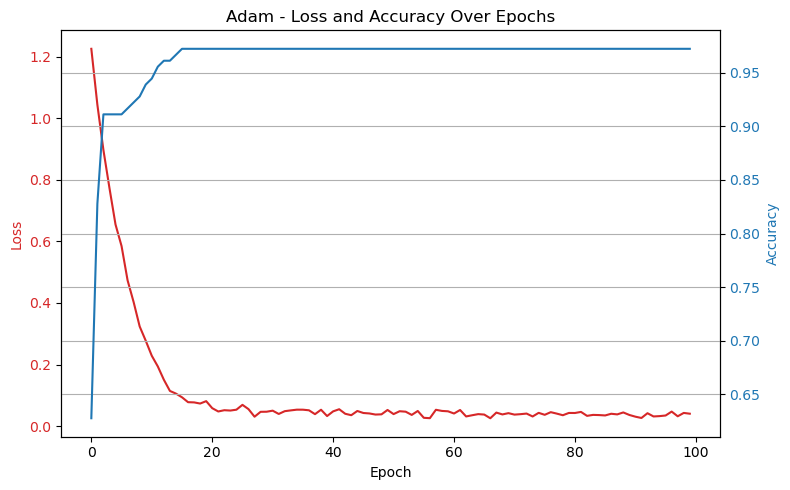

In [38]:
def plot_loss_accuracy_dual_axis(losses, accuracies, optimizer_name):
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # 左轴：训练 Loss
    ax1.plot(losses, color='tab:red', label='Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # 右轴：测试集 Accuracy
    ax2 = ax1.twinx()
    ax2.plot(accuracies, color='tab:blue', label='Accuracy')
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # 标题 & 图例
    plt.title(f"{optimizer_name} - Loss and Accuracy Over Epochs")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

for name in ["SGD", "Momentum", "RMSprop", "Adam"]:
    plot_loss_accuracy_dual_axis(tf_loss_histories[name], tf_acc_histories[name], name)

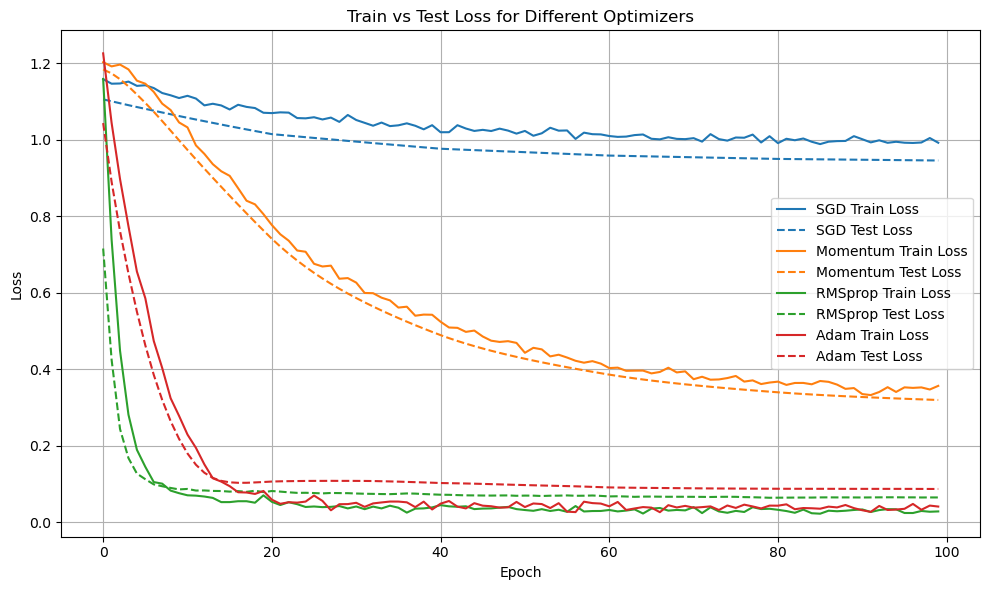

In [39]:
plt.figure(figsize=(10, 6))
colors = {
    "SGD": "tab:blue",
    "Momentum": "tab:orange",
    "RMSprop": "tab:green",
    "Adam": "tab:red"
}
for name in optimizers:
    color = colors[name]
    plt.plot(tf_loss_histories[name], label=f"{name} Train Loss", color=color, linestyle='-')
    plt.plot(tf_test_loss_histories[name], label=f"{name} Test Loss", color=color, linestyle='--')

plt.title("Train vs Test Loss for Different Optimizers")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.4 compare tensorflow and torch

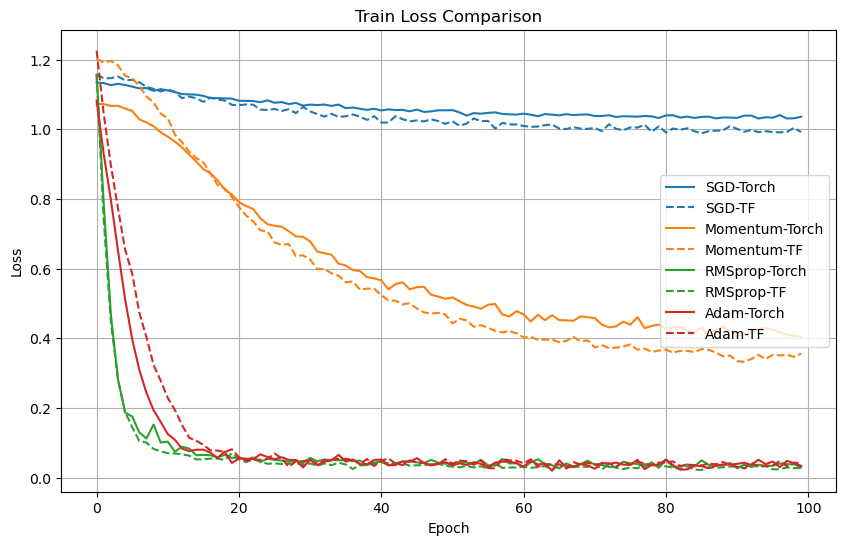

In [41]:
plt.figure(figsize=(10, 6))
colors = {
    "SGD": "tab:blue",
    "Momentum": "tab:orange",
    "RMSprop": "tab:green",
    "Adam": "tab:red"
}
for name in optimizers:
    color = colors[name]
    plt.plot(torch_loss_histories[name], color=color, label=f"{name}-Torch", linestyle="-")
    plt.plot(tf_loss_histories[name], color=color, label=f"{name}-TF", linestyle="--")
plt.title("Train Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()